In [1]:
#Loading up all necessary libraries
import pandas as pd
import numpy as np
import random
from datetime import timedelta, datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set seed for reproducibility
np.random.seed(42)

# Constants
num_candidates = 1000
domains = ['Biotech', 'Finance', 'Law', 'Engineering', 'Healthcare']
sources = ['LinkedIn', 'Referral', 'Email Campaign', 'Webinar', 'Job Board']

In [3]:
# Generate candidate IDs
candidate_ids = range(1, num_candidates + 1)

# Generate source and domain randomly
source_col = np.random.choice(sources, num_candidates)
domain_col = np.random.choice(domains, num_candidates)

# Qualification: 85% qualified
qualified_col = np.random.choice(['Y', 'N'], num_candidates, p=[0.85, 0.15])

In [4]:
# Dates for training started/completed based on qualification
start_date = datetime(2025, 6, 1)

# Initialize empty lists to store simulated values for each stage of the funnel
training_started_col = []
training_completed_col = []
evaluation_score_col = []
activated_col = []
time_to_activate_col = []

# Loop through each candidate
for i in range(num_candidates):
    
    # Check if candidate is qualified to proceed
    if qualified_col[i] == 'Y':
        
        # ~95% of qualified candidates start training
        if np.random.rand() < 0.95:
            # Generate a realistic training start date using exponential distribution (e.g., within ~5 days of sourcing)
            tsd = start_date + timedelta(days=int(np.random.exponential(scale=5)))
            training_started_col.append(tsd)

            # ~85% of those who start training complete it
            if np.random.rand() < 0.85:
                # Completion happens a few days after training started
                tcd = tsd + timedelta(days=int(np.random.exponential(scale=3)))
                training_completed_col.append(tcd)

                # ~75% of those who finish training pass an evaluation
                if np.random.rand() < 0.75:
                    # Generate evaluation score using normal distribution (mean ~85, std dev ~10)
                    score = np.random.normal(loc=85, scale=10)
                    evaluation_score_col.append(min(max(score, 0), 100))  # Keep score between 0 and 100

                    # ~80% of those who pass evaluation are activated and assigned to a client task
                    activated = 'Y' if np.random.rand() < 0.80 else 'N'
                    activated_col.append(activated)

                    # If activated, calculate time to activation (delay between passing eval and being placed)
                    if activated == 'Y':
                        days_to_activate = int(np.random.exponential(scale=4))
                        time_to_activate_col.append(days_to_activate)
                    else:
                        time_to_activate_col.append(None)

                else:
                    # Did not pass evaluation
                    evaluation_score_col.append(None)
                    activated_col.append('N')
                    time_to_activate_col.append(None)

            else:
                # Did not complete training
                training_completed_col.append(None)
                evaluation_score_col.append(None)
                activated_col.append('N')
                time_to_activate_col.append(None)

        else:
            # Did not start training
            training_started_col.append(None)
            training_completed_col.append(None)
            evaluation_score_col.append(None)
            activated_col.append('N')
            time_to_activate_col.append(None)

    else:
        # Not qualified at all
        training_started_col.append(None)
        training_completed_col.append(None)
        evaluation_score_col.append(None)
        activated_col.append('N')
        time_to_activate_col.append(None)


In [5]:
# Create DataFrame
df = pd.DataFrame({
    'candidate_id': candidate_ids,
    'source': source_col,
    'domain': domain_col,
    'qualified': qualified_col,
    'training_started_date': training_started_col,
    'training_completed_date': training_completed_col,
    'evaluation_score': evaluation_score_col,
    'activated': activated_col,
    'time_to_activate_days': time_to_activate_col
})

df

,candidate_id,source,domain,qualified,training_started_date,training_completed_date,evaluation_score,activated,time_to_activate_days
0,1,Webinar,Engineering,Y,2025-06-06,2025-06-12,100.000000,Y,0.0
1,2,Job Board,Engineering,Y,2025-06-02,2025-06-07,NaN,N,NaN
2,3,Email Campaign,Engineering,Y,2025-06-04,2025-06-08,72.096355,Y,1.0
3,4,Job Board,Engineering,Y,2025-06-05,2025-06-09,85.002071,Y,1.0
4,5,Job Board,Healthcare,Y,2025-06-01,2025-06-01,84.906997,Y,1.0
...,...,...,...,...,...,...,...,...,...
995,996,Referral,Biotech,Y,2025-06-06,2025-06-06,66.918221,Y,1.0
996,997,LinkedIn,Healthcare,Y,2025-06-02,2025-06-05,96.825944,N,NaN
997,998,LinkedIn,Biotech,Y,2025-06-01,NaT,NaN,N,NaN
998,999,Webinar,Healthcare,N,NaT,NaT,NaN,N,NaN


In [6]:
# Count total candidates at each stage
total = len(df)
qualified = df[df['qualified'] == 'Y'].shape[0]
training_started = df[df['training_started_date'].notna()].shape[0]
training_completed = df[df['training_completed_date'].notna()].shape[0]
evaluated = df[df['evaluation_score'].notna()].shape[0]
activated = df[df['activated'] == 'Y'].shape[0]

In [7]:
# Create funnel summary
funnel_counts = pd.DataFrame({
    'Stage': [
        'Sourced',
        'Qualified',
        'Training Started',
        'Training Completed',
        'Passed Evaluation',
        'Activated'
    ],
    'Candidates': [
        total,
        qualified,
        training_started,
        training_completed,
        evaluated,
        activated
    ]
})

In [8]:
# Add conversion rates from previous stage
funnel_counts['Conversion % (from prev)'] = funnel_counts['Candidates'].pct_change().fillna(1).apply
(lambda x: f"{x*100:.1f}%")

funnel_counts

,Stage,Candidates,Conversion % (from prev)
0,Sourced,1000,<bound method Series.apply of 0 1.000000\n1...
1,Qualified,855,<bound method Series.apply of 0 1.000000\n1...
2,Training Started,816,<bound method Series.apply of 0 1.000000\n1...
3,Training Completed,704,<bound method Series.apply of 0 1.000000\n1...
4,Passed Evaluation,529,<bound method Series.apply of 0 1.000000\n1...
5,Activated,417,<bound method Series.apply of 0 1.000000\n1...


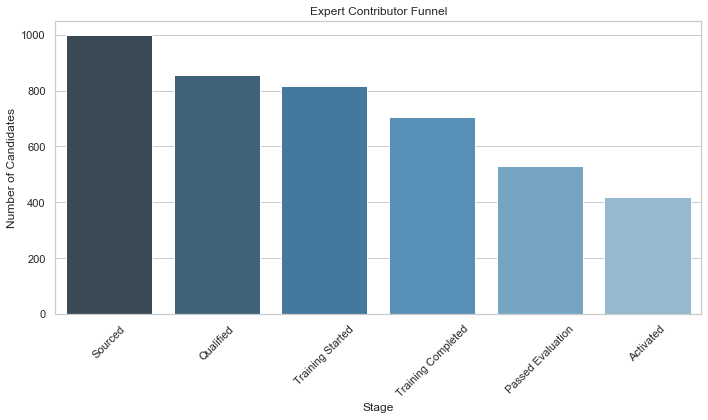

In [9]:
# Set style
sns.set(style="whitegrid")

# Bar chart for funnel stages
plt.figure(figsize=(10, 6))
sns.barplot(x='Stage', y='Candidates', data=funnel_counts, palette='Blues_d')
plt.title('Expert Contributor Funnel')
plt.ylabel('Number of Candidates')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# SQL Code

-- How many started training?

SELECT COUNT(*) FROM candidates WHERE training_started_date IS NOT NULL;
>> 816

-- Drop-off between training started vs completed

SELECT
  (SELECT COUNT(*) FROM candidates WHERE training_completed_date IS NOT NULL) * 1.0 /
  (SELECT COUNT(*) FROM candidates WHERE training_started_date IS NOT NULL) AS training_completion_rate;
  >>86.3%

-- Average evaluation score by domain

SELECT domain, AVG(evaluation_score)
FROM candidates
WHERE evaluation_score IS NOT NULL
GROUP BY domain;
>> 
Domain and Avg Evaluation Score
Engineering- 86.52,
Biotech- 84.89,
Finance- 84.43,
Healthcare- 84.08,
Law- 82.73